In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from committee_learning.ode import SphericalSquaredActivationODE
from committee_learning.initial_conditions import RandomNormalInitialConditions, SymmetricInitialConditions
from committee_learning.simulation import NormalizedSphericalConstraintSimulation
from committee_learning.result import SquareODEResult, SimulationResult
import numpy as np
from tqdm import tqdm

d = 10000
p = 1
k = 1
alpha = 0.1
noise = 0.#1e-3
dt = 1e-4
log_time = 2
id_n = 56
icid_n = 4

# The goal is to fix always the same initial conditions and then do many runs to see what happens
# # Just random
# ic = RandomNormalInitialConditions(p,k,d,spherical=True, seed=ic_seed)
# Wteacher, W0 = ic.Wteacher, ic.W0
# extra_string = ''

# Ortogonal
ic = {icid:SymmetricInitialConditions(p = p, k = k, epsilon=0., q0=1., seed = icid) for icid in range(icid_n)}
extra_string = '-orthogonal'

### Simulations

In [3]:
sim_times = []
sim_risks = []
sim_m = []
for ic_seed in tqdm(range(icid_n)):
  for id in tqdm(range(id_n),leave=False):
    Wteacher, W0 = ic[ic_seed].weights(d)
    sim = NormalizedSphericalConstraintSimulation(d,p,k,noise,Wteacher,alpha*p,'square',W0)
    # print(f'Simulating id = {id}')
    simr = SimulationResult(initial_condition=f'spherical-sde-test-browninian{extra_string}-icseed{ic_seed}', id=id)
    simr.from_file_or_run(sim,2+np.log10(sim.d),path='computation-database/sim/',force_read=True)
    if id == 0:
      sim_times = np.array(simr.steps)/d
    sim_risks.append(simr.macroscopic_risk())
    sim_m.append(simr.Ms)

sim_risks = np.array(sim_risks)
sim_m = np.einsum('stjr->st',np.array(sim_m))

100%|██████████| 4/4 [01:03<00:00, 15.90s/it]


### ODE

In [4]:
ode_times = []
ode_risks = []
for ic_seed in tqdm(range(icid_n)):
  ode = SphericalSquaredActivationODE(p,k,noise,alpha*p,ic[ic_seed].P,ic[ic_seed].Q,ic[ic_seed].M,dt)
  oder = SquareODEResult(initial_condition=f'spherical-phase-retrivial-ode{extra_string}-icseed{ic_seed}', id=ic_seed)
  oder.from_file_or_run(ode, log_time, path='computation-database/ode/')
  if ic_seed == 0:
    ode_times = np.array(oder.times)
  ode_risks.append(oder.risks)
ode_risks = np.array(ode_risks)

100%|██████████| 4/4 [00:01<00:00,  3.37it/s]


### SDE

In [5]:
from committee_learning.sde.phase_retrivial import SphericalPhaseRetrivialSDE

sde_times = []
sde_risks = []
sde_m = []

for ic_seed in tqdm(range(icid_n)):
  for id in tqdm(range(id_n)):
    sde = SphericalPhaseRetrivialSDE(noise, alpha*p, ic[ic_seed].P,ic[ic_seed].Q,ic[ic_seed].M, d, dt, seed=id)
    sder = SquareODEResult(initial_condition=f'spherical-phase-retrivial-sde{extra_string}-icseed{ic_seed}', id=id)
    sder.from_file_or_run(sde, log_time, path='computation-database/sde/')
    if id == 0:
      sde_times = np.array(sder.times)
    sde_risks.append(sder.risks)
    sde_m.append(sder.Ms)

sde_risks = np.array(sde_risks)
sde_m = np.einsum('stjr->st',np.array(sde_m))


100%|██████████| 4/4 [01:10<00:00, 17.68s/it]


### OrnsteinUhlenbeck

In [39]:
from committee_learning.sde.phase_retrivial.variance import _variance_q, _variance_m, _covariance_qm
from scipy.linalg import sqrtm
gamma = alpha*p
Sigma = np.array([[_variance_q(1,0,1,gamma,noise), _covariance_qm(1,0,1,gamma,noise)],
                  [_covariance_qm(1,0,1,gamma,noise), _variance_m(1,0,1,gamma,noise)]]
                ) / d
print(Sigma)
sigma_q, sigma_m = sqrtm(Sigma)
sigma = np.sqrt(np.sum(sigma_m**2))
mu = -1/2 * (8*gamma*(1-6*gamma)-4*gamma**2*noise) -3/8 * sum(sigma_q**2)

from committee_learning.sde.ornstein_uhlenbeck import OrnsteinUhlenbeck
import random

try:
  with open('computation-database/ornstein_uhlenbeck.npy', 'rb') as f:
    oru_times = np.load(f)
    oru_risks = np.load(f)
except FileNotFoundError:
  oru_times = []
  oru_ms = []
  for ic_seed in tqdm(range(icid_n)):
    random.seed(ic_seed)
    ic_rand = random.randint(0,10000000000)
    for id in tqdm(range(id_n), leave=False):
      oru = OrnsteinUhlenbeck(0.,mu,sigma,dt,0.01,id^ic_rand)
      oru.simulate(10**log_time)
      if ic_seed == 0:
        oru_times = np.array(oru.ts)
      oru_ms.append(oru.Xs)
  oru_risks = 2*(1-np.array(oru_ms)**2)
  with open('computation-database/ornstein_uhlenbeck.npy', 'wb') as f:
    np.save(f,oru_times)
    np.save(f,oru_risks)

[[2.9696e-04 0.0000e+00]
 [0.0000e+00 4.8000e-05]]


In [44]:
from mpmath import hyp2f2
from committee_learning.sde.phase_retrivial.variance import _variance_q, _variance_m, _covariance_qm
from scipy.linalg import sqrtm

def ode_exit_point(r):
  T = r**2
  return np.log(1/2 + 1/(2*p) - T/(2*k) + (d*T)/(2*k) - T/(2*p) + (d*T)/(2*p))/(8*gamma/(p*k)-4*(gamma/p)**2*(2/k+2/p+8/p**2+noise))
  
def exit_time(r):
  return (r/sigma)**2*float(hyp2f2(1,1,3/2,2,mu/sigma**2*r**2))

def measure_exit_time(risks, threshold, times):
  et_index = np.argmin(risks > threshold, axis = -1)
  return times[et_index]

In [62]:
from committee_learning.utilities import plot_style
import matplotlib.pyplot as plt

m_exit_threshold = 0.03

with plot_style():
  # fig, ax = plt.subplots(figsize=(2.75,2.75))
  fig, ax = plt.subplots(figsize=(5,5))
  ax.set_xlabel(r'$t$')
  ax.set_ylabel(r'$\mathcal{R}$')
  ax.set_xscale('log')
  ax.set_yscale('log')
  ax.set_xlim(1e0,100)
  ax.set_ylim(5e-2,2.25)
  
  ax.plot(sim_times, sim_risks.T,ls='-',lw=1.,marker='',ms=5.,c='blue',alpha=0.05)
  ax.plot(sde_times, sde_risks.T, ls='-',lw=1.,marker='',ms=2.,c='green', alpha=0.05)
  ax.plot(oru_times, oru_risks.T, ls='-',lw=1.,marker='',ms=2.,c='pink', alpha=0.05)

  ax.plot(oru_times, np.mean(oru_risks, axis = 0), label =f'Average OU', ls='-',lw=1.5,marker='',ms=2.,c='red')
  ax.plot(sde_times, np.mean(sde_risks, axis = 0), label =f'Average SDE', ls='-',lw=1.5,marker='',ms=2.,c='black')
  ax.plot(ode_times, np.mean(ode_risks, axis=0), label = 'Average ODE', ls='-',lw=1.5,marker='',ms=2.,c='yellow')
  ax.plot(sim_times, np.mean(sim_risks, axis = 0), label =f'Average sim.', ls='-',lw=1.5,marker='',ms=2.,c='blue')

  # fig.savefig(f'figures/spr_final.pdf', format = 'pdf', bbox_inches = 'tight')
  ax.set_xlim(1,100)
  # ax.set_ylim(1.75,2.25)
  # ax.set_xlim(.1,10)
  ax.set_ylim(1.99,2.01)
  ax.axhline(2*(1-m_exit_threshold**2),   ls='-.')
  t_sde = np.mean(measure_exit_time(sde_risks, 2*(1-m_exit_threshold**2),sde_times))
  ax.axvline(t_sde, ls='-.',c='black', label = f'$t_\\text{{SDE}} = {t_sde:.2f}$')
  t_sim = np.mean(measure_exit_time(sim_risks, 2*(1-m_exit_threshold**2),sim_times))
  ax.axvline(t_sim, ls='-.',c='blue', label = f'$t_\\text{{sim}} = {t_sim:.2f}$')
  t_oru = np.mean(measure_exit_time(oru_risks, 2*(1-m_exit_threshold**2),oru_times))
  ax.axvline(t_oru, ls='-.',c='red', label = f'$t_\\text{{oru}} = {t_oru:.2f}$')
  t_theo = exit_time(m_exit_threshold)
  ax.axvline(t_theo, ls='-.',c='green', label = f'$t_\\text{{theo SDE}} = {t_theo:.2f}$')
  t_theo_ode = ode_exit_point(m_exit_threshold)
  ax.axvline(t_theo_ode, ls='-.',c='orange', label = f'$t_\\text{{theo ODE}} = {t_theo_ode:.2f}$')
  ax.legend()
  fig.savefig(f'figures/spr_final_zoom.pdf', format = 'pdf', bbox_inches = 'tight')

**Probably there is so much noise after the drop because we are entering in what Ben Arus calls "balistic phase", and the Brownian motion it's not there anymore.**

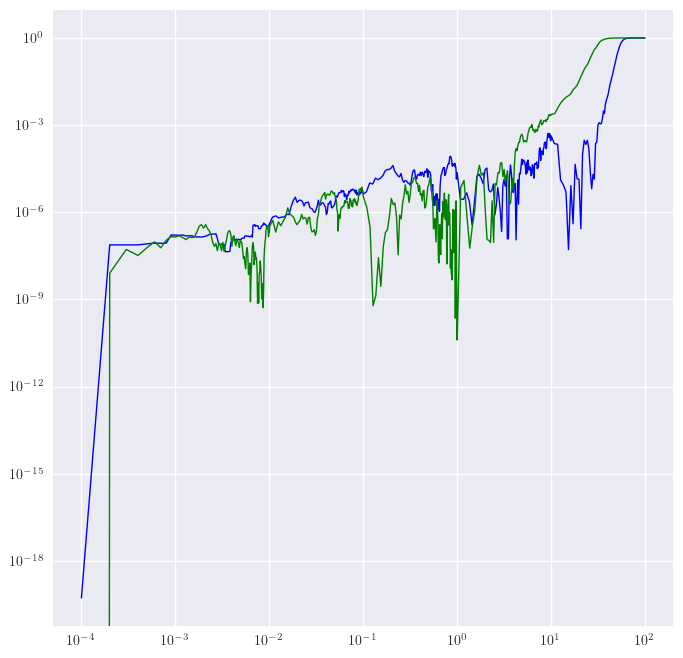

In [42]:
with plot_style():
  fig, ax = plt.subplots(figsize=(8,8))
  ax.set_xscale('log')
  ax.set_yscale('log')
  # ax.set_xlim(1,100)
  # ax.set_ylim(.00001,1.6)

  ax.plot(np.array(simr.steps)/d, abs(np.reshape(np.array(simr.Ms),(500,)))**2, label = 'sim', ls='-',lw=1.,marker='',ms=2.,c='blue')
  ax.plot(oder.times, abs(np.reshape(np.array(oder.Ms),(513,)))**2, label = 'ODE', ls='-',lw=1.,marker='',ms=2.,c='yellow')
  ax.plot(oder.times, abs(np.reshape(np.array(sder.Ms),(513,)))**2, label = 'SDE', ls='-',lw=1.,marker='',ms=2.,c='green')
  plt.show()